In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [70]:
df = pd.read_csv('/kaggle/input/aapl-stock-data-hourly/AAPL Hourly.csv')
df = df[['timestamp', 'close']]

In [71]:
df=df.set_index('timestamp')

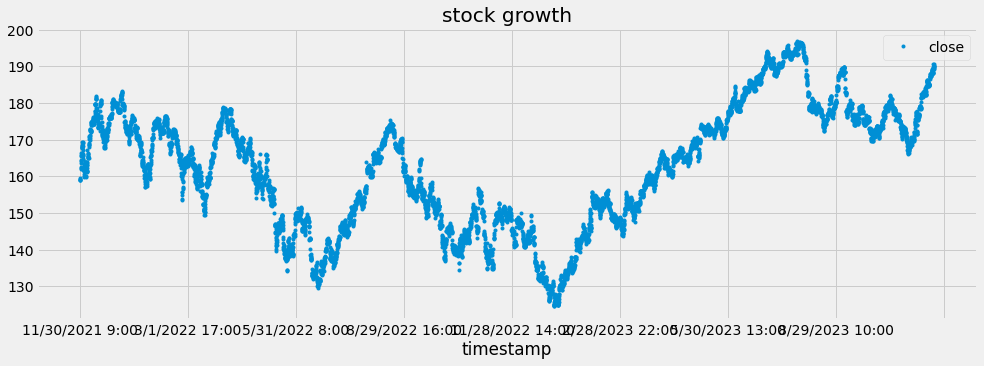

In [72]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='stock growth')
plt.show()

In [73]:
df.head()

,close
timestamp,
11/30/2021 9:00,159.10
11/30/2021 10:00,159.17
11/30/2021 11:00,158.96
11/30/2021 12:00,159.11
11/30/2021 13:00,159.59


In [74]:
mean  = df['close'].mean()
mean

162.3033402402023

In [75]:
df.index=pd.to_datetime(df.index)

# Train / Test Split

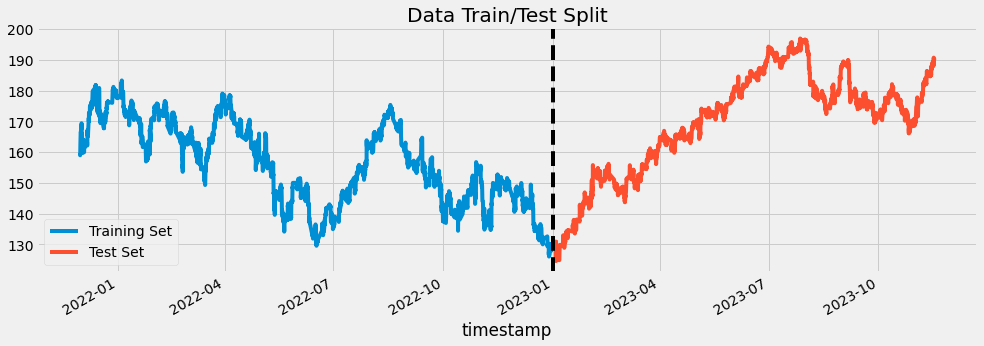

In [76]:
train = df.loc[df.index < '01/01/2023']
test = df.loc[df.index >= '01/01/2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [105]:
df

,close,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,
2021-11-30 09:00:00,159.10,9,1,4,11,2021,334,30,48
2021-11-30 10:00:00,159.17,10,1,4,11,2021,334,30,48
2021-11-30 11:00:00,158.96,11,1,4,11,2021,334,30,48
2021-11-30 12:00:00,159.11,12,1,4,11,2021,334,30,48
2021-11-30 13:00:00,159.59,13,1,4,11,2021,334,30,48
...,...,...,...,...,...,...,...,...,...
2023-11-16 20:00:00,189.77,20,3,4,11,2023,320,16,46
2023-11-16 21:00:00,190.10,21,3,4,11,2023,320,16,46
2023-11-16 22:00:00,189.96,22,3,4,11,2023,320,16,46


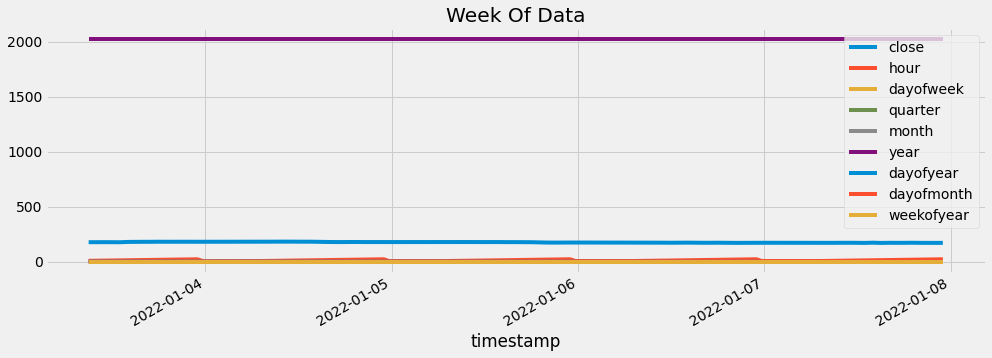

In [107]:
df.loc[(df.index > '01/01/2022') & (df.index < '01/08/2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [91]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

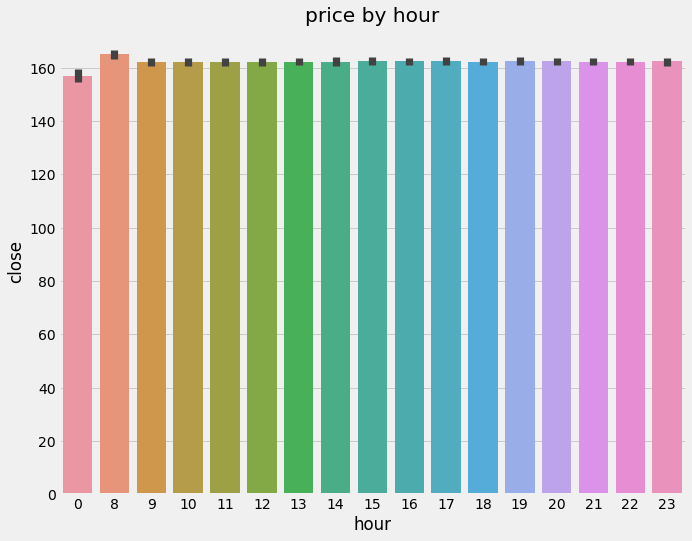

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df, x='hour', y='close')
ax.set_title('price by hour')
plt.show()

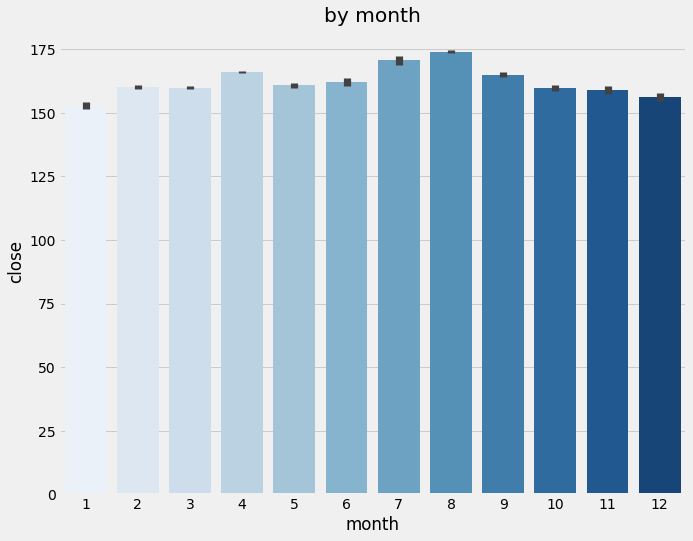

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('by month')
plt.show()

# Create our Model

In [97]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [177]:
reg = xgb.XGBRegressor(base_score=mean,    
                       n_estimators=1000,
                       early_stopping_rounds=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:13.77227	validation_1-rmse:19.10013
[100]	validation_0-rmse:2.21008	validation_1-rmse:28.93545
[200]	validation_0-rmse:1.69919	validation_1-rmse:29.13252
[300]	validation_0-rmse:1.53636	validation_1-rmse:29.19358
[400]	validation_0-rmse:1.43590	validation_1-rmse:29.21800
[500]	validation_0-rmse:1.36775	validation_1-rmse:29.23179
[600]	validation_0-rmse:1.30781	validation_1-rmse:29.24437
[700]	validation_0-rmse:1.26732	validation_1-rmse:29.24926
[800]	validation_0-rmse:1.23259	validation_1-rmse:29.25145
[900]	validation_0-rmse:1.20048	validation_1-rmse:29.25439
[999]	validation_0-rmse:1.17463	validation_1-rmse:29.25731


XGBRegressor(base_score=162.3033402402023, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=1000, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# Forecast on Test

In [174]:
test['prediction'] = reg.predict(X_test)

test

,close,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
timestamp,,,,,,,,,,
2023-01-03 09:00:00,131.30,9,1,1,1,2023,3,3,1,164.010681
2023-01-03 10:00:00,131.00,10,1,1,1,2023,3,3,1,164.010681
2023-01-03 11:00:00,130.38,11,1,1,1,2023,3,3,1,164.010681
2023-01-03 12:00:00,130.50,12,1,1,1,2023,3,3,1,164.010681
2023-01-03 13:00:00,130.92,13,1,1,1,2023,3,3,1,164.010681
...,...,...,...,...,...,...,...,...,...,...
2023-11-16 20:00:00,189.77,20,3,4,11,2023,320,16,46,160.358215
2023-11-16 21:00:00,190.10,21,3,4,11,2023,320,16,46,160.358215
2023-11-16 22:00:00,189.96,22,3,4,11,2023,320,16,46,160.358215


In [175]:
test['prediction'].mean()

161.7173

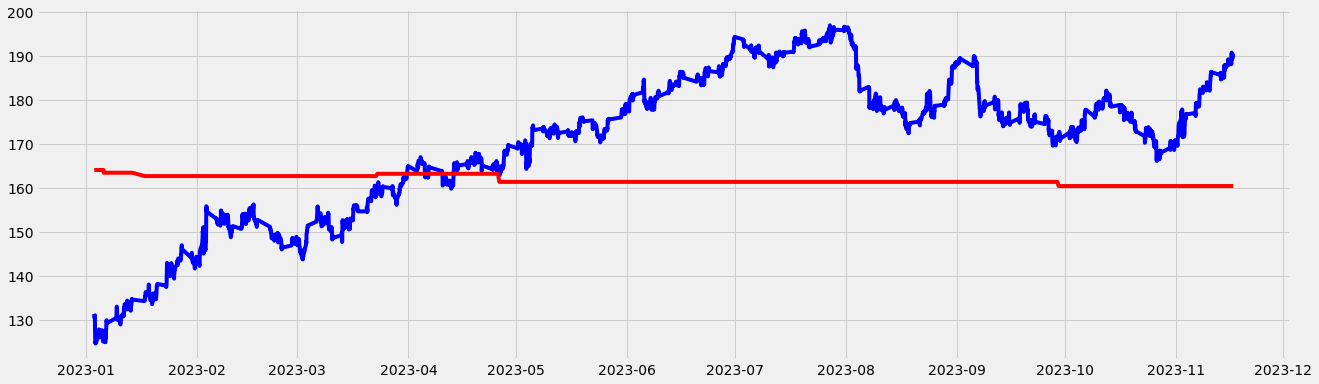

In [176]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 6))
plt.plot(test['close'], label='Actual', color='blue')
plt.plot(test['prediction'], label='Predicted', color='red')

In [ ]:
df = pd.merge(df, test, on="time")

In [51]:
df.tail()

,close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction_x,prediction_y,prediction
timestamp,,,,,,,,,,,,,
2023-11-16 20:00:00,189.77,3,4,11,2023,320,16,46,146.047852,146.047852,146.047852,146.047852,162.28389
2023-11-16 21:00:00,190.10,3,4,11,2023,320,16,46,146.047852,146.047852,146.047852,146.047852,162.28389
2023-11-16 22:00:00,189.96,3,4,11,2023,320,16,46,146.047852,146.047852,146.047852,146.047852,162.28389
2023-11-16 23:00:00,190.04,3,4,11,2023,320,16,46,146.047852,146.047852,146.047852,146.047852,162.28389
2023-11-17 00:00:00,190.51,4,4,11,2023,321,17,46,146.047852,146.047852,146.047852,146.047852,162.28389


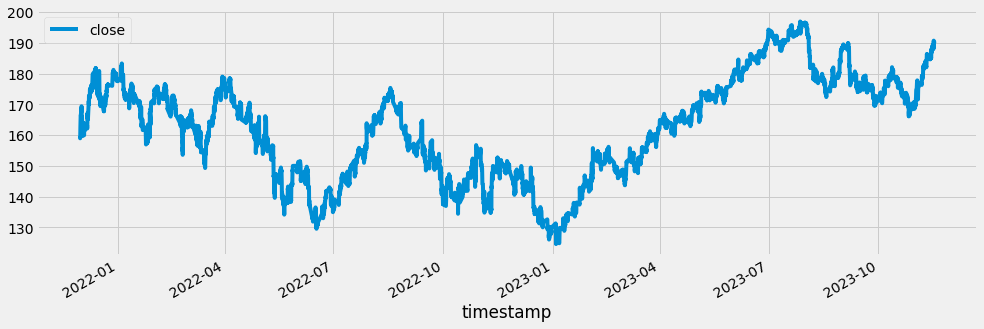

In [31]:
ax = df[['close']].plot(figsize=(15, 5))


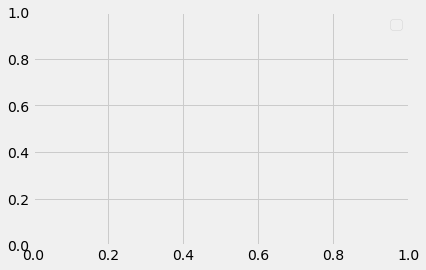

In [32]:
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [34]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 28.61


# Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End